In [24]:
# 1) PyTorch 2.1.0 제거-후 2.0.1 설치
#!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 \
 #   --index-url https://download.pytorch.org/whl/cu118 --force-reinstall

In [25]:
#!pip install functorch --upgrade

In [26]:
#@title Attention Is All You Need
# encoder - 6 layers - 2 sublayers - MHA, FFN
# decoder – 6 layers – 3 sublayers – masked MHA, MHA, FFN

import torch
from torch import nn
import functorch
import math
import datasets
import spacy
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt

class Attention(nn.Module):
  def __init__(self, d_model = 512, num_heads = 8, dropout = 0.1):
    super().__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask = None): # mask is optional
    b, s, _ = x.size() # b = batch_size, s = seq_len
    # (bs, seq, num_heads, d_k) → (bs, num_heads, seq, d_k)
    q = self.w_q(x).view(b, s, self.num_heads, self.d_k).transpose(1,2)
    k = self.w_k(x).view(b, s, self.num_heads, self.d_k).transpose(1,2)
    v = self.w_v(x).view(b, s, self.num_heads, self.d_k).transpose(1,2)

    # scaling dividing by math.sqrt(self.d_k)
    attn_out = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
    if mask is not None:
      # mask changes pos 0 to -inf so that makes prob to 0 after softmax
      attn_out = attn_out.masked_fill(mask == 0, float('-inf'))
    attn_out = torch.softmax(attn_out, dim=-1)
    attn_out = self.dropout(attn_out)
    attn_out = torch.matmul(attn_out, v)
    attn_out = attn_out.transpose(1,2).reshape(b, s, self.d_model)
    attn_out = self.w_o(attn_out)

    return attn_out

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model = 512, num_heads = 8, dropout = 0.1):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self, q, k, v, mask = None):
    b, q_len, _ = q.size() # b = batch_size, s = seq_len
    b, kv_len, _ = k.size()
    # (bs, seq, num_heads, d_k) → (bs, num_heads, seq, d_k)
    q = self.w_q(q).view(b, q_len, self.num_heads, self.d_k).transpose(1,2)
    k = self.w_k(k).view(b, kv_len, self.num_heads, self.d_k).transpose(1,2)
    v = self.w_v(v).view(b, kv_len, self.num_heads, self.d_k).transpose(1,2)

    # scaling dividing by math.sqrt(self.d_k)
    attn_out = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
    if mask is not None:
      # mask changes pos 0 to -inf so that makes prob to 0 after softmax
      attn_out = attn_out.masked_fill(mask == 0, float('-inf'))
    attn_out = torch.softmax(attn_out, dim=-1)
    attn_out = self.dropout(attn_out)
    attn_out = torch.matmul(attn_out, v)
    attn_out = attn_out.transpose(1,2).reshape(b, q_len, self.d_model)
    attn_out = self.w_o(attn_out)

    return attn_out

def look_ahead_mask_(size):
    mask = torch.tril(torch.ones(size, size))

    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, size, size)

class Encoder(nn.Module):
  def __init__(self, d_model = 512, num_heads = 8, dropout = 0.1):
    super().__init__()

    self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
    self.dropout1 = nn.Dropout(dropout)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.ffn = FeedForward(d_model)
    self.dropout2 = nn.Dropout(dropout)
    self.layer_norm2 = nn.LayerNorm(d_model)

  def forward(self, x, mask = None):
    attention_out = self.self_attention(x, x, x, mask)
    x = x + self.dropout1(attention_out)
    x = self.layer_norm1(x)

    ffn_out = self.ffn(x)
    x = x + self.dropout2(ffn_out)
    x = self.layer_norm2(x)

    return x

class Decoder(nn.Module):
  def __init__(self, d_model = 512, num_heads = 8, dropout = 0.1):
    super().__init__()

    self.self_attention = MultiHeadAttention(d_model, num_heads, dropout) #Masked MHA
    self.dropout1 = nn.Dropout(dropout)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.enc_dec_attention = MultiHeadAttention(d_model, num_heads, dropout) #Masked MHA
    self.dropout2 = nn.Dropout(dropout)
    self.layer_norm2 = nn.LayerNorm(d_model)

    self.ffn = FeedForward(d_model)
    self.dropout3 = nn.Dropout(dropout)
    self.layer_norm3 = nn.LayerNorm(d_model)

  def forward(self, x, enc_output, look_ahead_mask_ = None, mask = None):
    attention_out = self.self_attention(x, x, x, look_ahead_mask_)
    x = x + self.dropout1(attention_out)
    x = self.layer_norm1(x)

    attention_out = self.enc_dec_attention(x, enc_output, enc_output, mask)
    x = x + self.dropout2(attention_out)
    x = self.layer_norm2(x)

    ffn_out = self.ffn(x)
    x = x + self.dropout3(ffn_out)
    x = self.layer_norm3(x)

    return x

class EncoderStack(nn.Module):
    def __init__(self, num_layers = 6, d_model = 512, num_heads = 8, dropout = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            Encoder(d_model, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class DecoderStack(nn.Module):
    def __init__(self, num_layers = 6, d_model = 512, num_heads = 8, dropout = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            Decoder(d_model, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_output, look_ahead_mask_=None, mask=None):
        for layer in self.layers:
            x = layer(x, enc_output, look_ahead_mask_, mask)
        return x


class FeedForward(nn.Module):
  def __init__(self, d_model = 512, num_heads = 8, d_ff = 2048, dropout = 0.1):
    super().__init__()

    self.linear1 = nn.Linear(d_model, d_ff)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)

    return x

class Embedding(nn.Module):
  def __init__(self, vocab_size, d_model = 512): # vocab_size is the total number of words/tokens
    super().__init__()
    self.d_model = d_model
    self.emb = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.emb(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
  def __init__(self, d_model = 512, max_len = 5000, dropout=0.1): # vocab_size is the total number of words/tokens
    super().__init__()
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    dim = torch.arange(0, d_model, 2)
    pe[:, 0::2] = torch.sin(position / (10_000 ** (dim / self.d_model)))
    pe[:, 1::2] = torch.cos(position / (10_000 ** (dim / self.d_model)))

    pe = pe.unsqueeze(0)  # (1, max_len, d_model)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:, : x.size(1)].detach()
    return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()

        self.src_embedding = Embedding(src_vocab_size, d_model)
        self.tgt_embedding = Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)

        self.encoder = EncoderStack(num_layers, d_model, num_heads, dropout)
        self.decoder = DecoderStack(num_layers, d_model, num_heads, dropout)

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.src_embedding(src)
        src = self.pos_encoding(src)

        tgt = self.tgt_embedding(tgt)
        tgt = self.pos_encoding(tgt)

        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, tgt_mask, src_mask)

        output = self.fc_out(dec_output)
        return output

In [27]:
!pip install -q datasets spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 128.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 83.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [28]:
#!pip install numpy --upgrade --force-reinstall
import numpy as np

In [29]:
# Tokenizer
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

# Data loading
raw_data = datasets.load_dataset("opus_books", "de-en")
raw_data = raw_data["train"].train_test_split(test_size=0.1)
train_data = raw_data["train"]
val_data = raw_data["test"]

# Max length of sentence
MAX_LEN = 40

# Data preprocessing
def preprocess(data):
    src_tokenized = []
    tgt_tokenized = []
    for ex in data:
        src = tokenize_en(ex["translation"]["en"])
        tgt = tokenize_de(ex["translation"]["de"])
        if len(src) <= MAX_LEN and len(tgt) <= MAX_LEN:
            src_tokenized.append(["<sos>"] + src + ["<eos>"])
            tgt_tokenized.append(["<sos>"] + tgt + ["<eos>"])
    return src_tokenized, tgt_tokenized

src_sentences, tgt_sentences = preprocess(train_data)

# Generating vocabulary
def build_vocab(sentences, min_freq=2):
    counter = Counter()
    for sent in sentences:
        counter.update(sent)
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for word, freq in counter.items():
        if freq >= min_freq and word not in vocab:
            vocab[word] = len(vocab)
    return vocab

src_vocab = build_vocab(src_sentences)
tgt_vocab = build_vocab(tgt_sentences)

# Tensor transformation
def numericalize(sent, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in sent]

class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src = src_sentences
        self.tgt = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_tensor = torch.tensor(numericalize(self.src[idx], self.src_vocab))
        tgt_tensor = torch.tensor(numericalize(self.tgt[idx], self.tgt_vocab))
        return src_tensor, tgt_tensor

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=src_vocab["<pad>"])
    tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=tgt_vocab["<pad>"])
    return src_batch, tgt_batch

# DataLoader
train_dataset = TranslationDataset(src_sentences, tgt_sentences, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Verification
for src, tgt in train_loader:
    print("SRC (input):", src.shape)  # [batch_size, src_len]
    print("TGT (target):", tgt.shape)  # [batch_size, tgt_len]
    break

# Total number of vocabulary
print(f"Source Vocab Size: {len(src_vocab)}")
print(f"Target Vocab Size: {len(tgt_vocab)}")


SRC (input): torch.Size([32, 42])
TGT (target): torch.Size([32, 41])
Source Vocab Size: 12470
Target Vocab Size: 17332


In [30]:
#@title batch for the model
# Device Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generating mask
def make_src_mask(src, pad_idx):
    return (src != pad_idx).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, src_len]

def make_tgt_mask(tgt, pad_idx):
    B, T = tgt.size()

    # Padding mask
    pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]

    # Look-ahead mask
    look_ahead_mask = torch.tril(torch.ones((T, T), device=tgt.device)).bool()  # [T, T]
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, T, T]

    return pad_mask & look_ahead_mask # [B, 1, T, T]

# Transformer model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=512,
    num_heads=8,
    num_layers=6,
    dropout=0.1
).to(device)

# Example batch to check Forward pass
pad_idx_src = src_vocab["<pad>"]
pad_idx_tgt = tgt_vocab["<pad>"]

# A batch for the model
for src_batch, tgt_batch in train_loader:
    # input: src, tgt_input / output: tgt_output
    src = src_batch.to(device)
    tgt_input = tgt_batch[:, :-1].to(device)
    tgt_output = tgt_batch[:, 1:].to(device)

    src_mask = make_src_mask(src, pad_idx_src).to(device)
    tgt_mask = make_tgt_mask(tgt_input, pad_idx_tgt).to(device)

    # Output verification
    with torch.no_grad():
      output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)
    print("Output shape:", output.shape) # [B, tgt_len-1, vocab]
    print("Target shape:", tgt_output.shape) # [B, tgt_len-1]

    break


Output shape: torch.Size([32, 41, 17332])
Target shape: torch.Size([32, 41])


In [31]:
#@title Training the model

# padding token index
pad_idx_src = src_vocab["<pad>"]
pad_idx_tgt = tgt_vocab["<pad>"]

# Transformer model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=512,
    num_heads=8,
    num_layers=6,
    dropout=0.1
).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx_tgt)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Generating mask
def make_src_mask(src, pad_idx):
    return (src != pad_idx).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, src_len]

def make_tgt_mask(tgt, pad_idx):
    B, T = tgt.size()
    pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]
    look_ahead_mask = torch.tril(torch.ones((T, T), device=tgt.device)).bool()
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, T, T]
    return pad_mask & look_ahead_mask

# Validation data preprocessing and generating DataLoader
val_src_sentences, val_tgt_sentences = preprocess(val_data)
val_dataset = TranslationDataset(val_src_sentences, val_tgt_sentences, src_vocab, tgt_vocab)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Result lists
train_losses = []
val_losses = []
val_accuracies = []

# The number of epochs
NUM_EPOCHS = 100

# Training
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for src_batch, tgt_batch in tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]"):
        src = src_batch.to(device)
        tgt_input = tgt_batch[:, :-1].to(device)
        tgt_output = tgt_batch[:, 1:].to(device)

        src_mask = make_src_mask(src, pad_idx_src)
        tgt_mask = make_tgt_mask(tgt_input, pad_idx_tgt)

        # forward propagation
        output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)

        # Loss calculation and backward propagation
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

    # Validation evaluation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for src_batch, tgt_batch in val_loader:
            src = src_batch.to(device)
            tgt_input = tgt_batch[:, :-1].to(device)
            tgt_output = tgt_batch[:, 1:].to(device)

            src_mask = make_src_mask(src, pad_idx_src)
            tgt_mask = make_tgt_mask(tgt_input, pad_idx_tgt)

            output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)  # [B, T, vocab]

            # Validation loss
            output_flat = output.reshape(-1, output.shape[-1])
            tgt_flat   = tgt_output.reshape(-1)
            loss = criterion(output_flat, tgt_flat)
            val_loss += loss.item()

            # Validation accuracy
            preds   = output.argmax(dim=-1)           # [B, T]
            non_pad = tgt_output != pad_idx_tgt
            correct += ((preds == tgt_output) & non_pad).sum().item()
            total   += non_pad.sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy     = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)


[Train Epoch 1]: 100%|██████████| 1159/1159 [02:51<00:00,  6.76it/s]


[Epoch 1] Train Loss: 5.2945


[Train Epoch 2]: 100%|██████████| 1159/1159 [02:50<00:00,  6.82it/s]


[Epoch 2] Train Loss: 4.4841


[Train Epoch 3]: 100%|██████████| 1159/1159 [02:49<00:00,  6.82it/s]


[Epoch 3] Train Loss: 4.0981


[Train Epoch 4]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 4] Train Loss: 3.7931


[Train Epoch 5]: 100%|██████████| 1159/1159 [02:50<00:00,  6.82it/s]


[Epoch 5] Train Loss: 3.5297


[Train Epoch 6]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 6] Train Loss: 3.2850


[Train Epoch 7]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 7] Train Loss: 3.0516


[Train Epoch 8]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 8] Train Loss: 2.8216


[Train Epoch 9]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 9] Train Loss: 2.5951


[Train Epoch 10]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 10] Train Loss: 2.3789


[Train Epoch 11]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 11] Train Loss: 2.1562


[Train Epoch 12]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 12] Train Loss: 1.9449


[Train Epoch 13]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 13] Train Loss: 1.7433


[Train Epoch 14]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 14] Train Loss: 1.5590


[Train Epoch 15]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 15] Train Loss: 1.3865


[Train Epoch 16]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 16] Train Loss: 1.2347


[Train Epoch 17]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 17] Train Loss: 1.0946


[Train Epoch 18]: 100%|██████████| 1159/1159 [02:49<00:00,  6.82it/s]


[Epoch 18] Train Loss: 0.9739


[Train Epoch 19]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 19] Train Loss: 0.8709


[Train Epoch 20]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 20] Train Loss: 0.7765


[Train Epoch 21]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 21] Train Loss: 0.6996


[Train Epoch 22]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 22] Train Loss: 0.6313


[Train Epoch 23]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 23] Train Loss: 0.5811


[Train Epoch 24]: 100%|██████████| 1159/1159 [02:50<00:00,  6.82it/s]


[Epoch 24] Train Loss: 0.5287


[Train Epoch 25]: 100%|██████████| 1159/1159 [02:49<00:00,  6.82it/s]


[Epoch 25] Train Loss: 0.4928


[Train Epoch 26]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 26] Train Loss: 0.4500


[Train Epoch 27]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 27] Train Loss: 0.4263


[Train Epoch 28]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 28] Train Loss: 0.4002


[Train Epoch 29]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 29] Train Loss: 0.3792


[Train Epoch 30]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 30] Train Loss: 0.3560


[Train Epoch 31]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 31] Train Loss: 0.3431


[Train Epoch 32]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 32] Train Loss: 0.3278


[Train Epoch 33]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 33] Train Loss: 0.3097


[Train Epoch 34]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 34] Train Loss: 0.2992


[Train Epoch 35]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 35] Train Loss: 0.2906


[Train Epoch 36]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 36] Train Loss: 0.2762


[Train Epoch 37]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 37] Train Loss: 0.2703


[Train Epoch 38]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 38] Train Loss: 0.2623


[Train Epoch 39]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 39] Train Loss: 0.2540


[Train Epoch 40]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 40] Train Loss: 0.2442


[Train Epoch 41]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 41] Train Loss: 0.2413


[Train Epoch 42]: 100%|██████████| 1159/1159 [02:50<00:00,  6.82it/s]


[Epoch 42] Train Loss: 0.2313


[Train Epoch 43]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 43] Train Loss: 0.2292


[Train Epoch 44]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 44] Train Loss: 0.2217


[Train Epoch 45]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 45] Train Loss: 0.2160


[Train Epoch 46]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 46] Train Loss: 0.2111


[Train Epoch 47]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 47] Train Loss: 0.2065


[Train Epoch 48]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 48] Train Loss: 0.2049


[Train Epoch 49]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 49] Train Loss: 0.1984


[Train Epoch 50]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 50] Train Loss: 0.1953


[Train Epoch 51]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 51] Train Loss: 0.1942


[Train Epoch 52]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 52] Train Loss: 0.1887


[Train Epoch 53]: 100%|██████████| 1159/1159 [02:49<00:00,  6.83it/s]


[Epoch 53] Train Loss: 0.1857


[Train Epoch 54]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 54] Train Loss: 0.1832


[Train Epoch 55]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 55] Train Loss: 0.1760


[Train Epoch 56]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 56] Train Loss: 0.1765


[Train Epoch 57]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 57] Train Loss: 0.1720


[Train Epoch 58]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 58] Train Loss: 0.1718


[Train Epoch 59]: 100%|██████████| 1159/1159 [02:49<00:00,  6.86it/s]


[Epoch 59] Train Loss: 0.1659


[Train Epoch 60]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 60] Train Loss: 0.1635


[Train Epoch 61]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 61] Train Loss: 0.1625


[Train Epoch 62]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 62] Train Loss: 0.1599


[Train Epoch 63]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 63] Train Loss: 0.1597


[Train Epoch 64]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 64] Train Loss: 0.1552


[Train Epoch 65]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 65] Train Loss: 0.1544


[Train Epoch 66]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 66] Train Loss: 0.1523


[Train Epoch 67]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 67] Train Loss: 0.1487


[Train Epoch 68]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 68] Train Loss: 0.1478


[Train Epoch 69]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 69] Train Loss: 0.1461


[Train Epoch 70]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 70] Train Loss: 0.1463


[Train Epoch 71]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 71] Train Loss: 0.1454


[Train Epoch 72]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 72] Train Loss: 0.1386


[Train Epoch 73]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 73] Train Loss: 0.1397


[Train Epoch 74]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 74] Train Loss: 0.1380


[Train Epoch 75]: 100%|██████████| 1159/1159 [02:49<00:00,  6.86it/s]


[Epoch 75] Train Loss: 0.1387


[Train Epoch 76]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 76] Train Loss: 0.1364


[Train Epoch 77]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 77] Train Loss: 0.1332


[Train Epoch 78]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 78] Train Loss: 0.1343


[Train Epoch 79]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 79] Train Loss: 0.1314


[Train Epoch 80]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 80] Train Loss: 0.1290


[Train Epoch 81]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 81] Train Loss: 0.1282


[Train Epoch 82]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 82] Train Loss: 0.1289


[Train Epoch 83]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 83] Train Loss: 0.1263


[Train Epoch 84]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 84] Train Loss: 0.1288


[Train Epoch 85]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 85] Train Loss: 0.1234


[Train Epoch 86]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 86] Train Loss: 0.1239


[Train Epoch 87]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 87] Train Loss: 0.1230


[Train Epoch 88]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 88] Train Loss: 0.1205


[Train Epoch 89]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 89] Train Loss: 0.1211


[Train Epoch 90]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 90] Train Loss: 0.1190


[Train Epoch 91]: 100%|██████████| 1159/1159 [02:49<00:00,  6.84it/s]


[Epoch 91] Train Loss: 0.1184


[Train Epoch 92]: 100%|██████████| 1159/1159 [02:48<00:00,  6.86it/s]


[Epoch 92] Train Loss: 0.1169


[Train Epoch 93]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 93] Train Loss: 0.1180


[Train Epoch 94]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 94] Train Loss: 0.1154


[Train Epoch 95]: 100%|██████████| 1159/1159 [02:49<00:00,  6.85it/s]


[Epoch 95] Train Loss: 0.1156


[Train Epoch 96]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 96] Train Loss: 0.1156


[Train Epoch 97]: 100%|██████████| 1159/1159 [02:48<00:00,  6.87it/s]


[Epoch 97] Train Loss: 0.1135


[Train Epoch 98]: 100%|██████████| 1159/1159 [02:48<00:00,  6.90it/s]


[Epoch 98] Train Loss: 0.1142


[Train Epoch 99]: 100%|██████████| 1159/1159 [02:48<00:00,  6.88it/s]


[Epoch 99] Train Loss: 0.1124


[Train Epoch 100]: 100%|██████████| 1159/1159 [02:48<00:00,  6.89it/s]


[Epoch 100] Train Loss: 0.1091


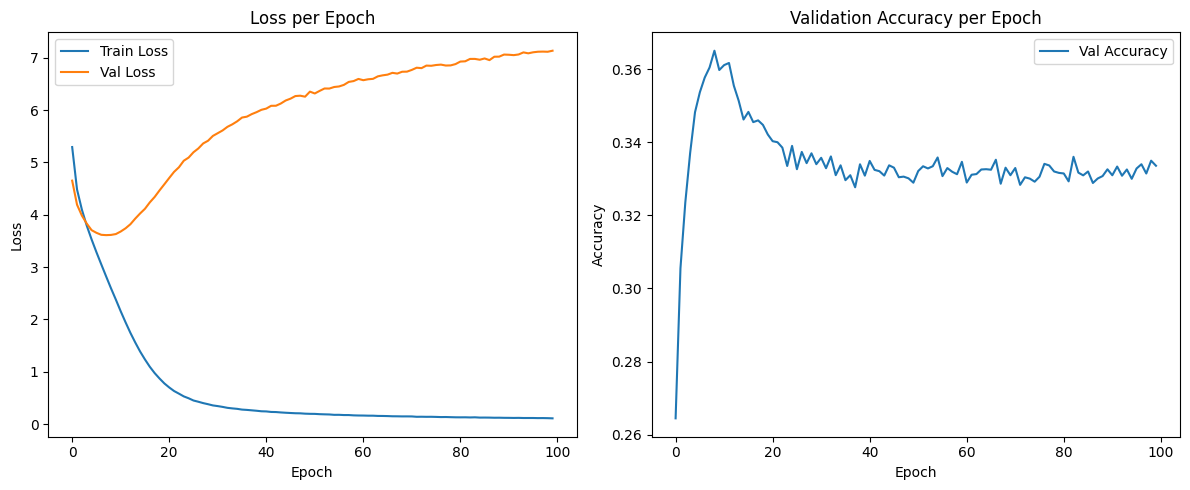

In [32]:
#@title Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()